Setup & Imports

In [3]:
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from src.preprocessing import preprocess_all

In [4]:
sns.set(style="whitegrid")
np.random.seed(42)

Load Data

In [5]:
df = pd.read_csv(
    "../data/fullcifocoss.csv",
    sep=';',
    engine='python',
    encoding='utf-8',
    quotechar='"',
    on_bad_lines='skip'
)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (616252, 26)


,BW,Country,Year,FoodCode,FoodName,AgeClass,SourceAgeClass,Gender,Number_of_consumers,Consumers_Mean,...,Number_of_subjects,Total_Mean,Total_Median,Total_P05,Total_P90,Total_P95,Total_P975,Total_Standard_deviation,ExtBW,ExtBWValue
0,0,China,2002,A000G,Oat grain,All,All,All,1157,60.6230,...,66172,1.0600,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
1,0,China,2002,A000G,Oat grain,All,All,female,608,55.8676,...,33953,1.0004,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2,0,China,2002,A000G,Oat grain,All,All,male,549,65.8895,...,32219,1.1227,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
3,0,China,2002,A000N,Buckwheat,All,All,All,167,55.2645,...,66172,0.1395,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
4,0,China,2002,A000N,Buckwheat,All,All,female,82,54.7053,...,33953,0.1321,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN


Exploratory Data Analysis (EDA)


Missing values per column:
 ExtBWValue                      604888
ExtBW                           557867
Total_P90                       380406
Consumers_P90                   371363
Consumers_Standard_deviation      9064
Total_Standard_deviation          9064
Total_P975                        9064
Total_Mean                        5102
Consumers_Median                  4532
Consumers_P05                      910
FoodName                            82
Consumers_Mean                      32
Consumers_P95                       20
Consumers_P975                      20
Total_P95                           14
Total_Median                         3
BW                                   0
Country                              0
Number_of_consumers                  0
Gender                               0
SourceAgeClass                       0
AgeClass                             0
Year                                 0
FoodCode                             0
Number_of_subjects                  

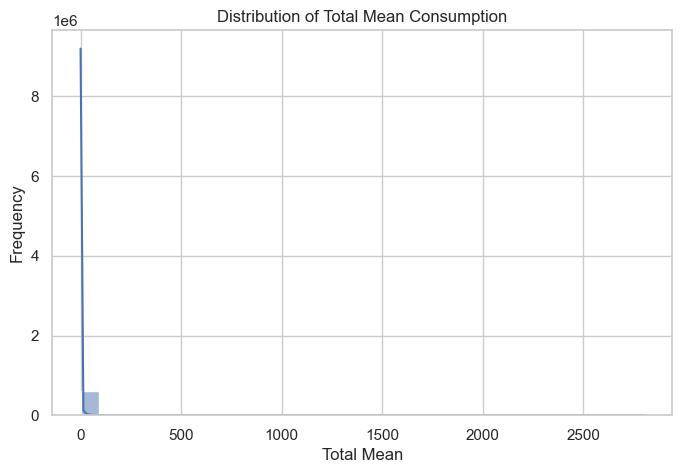

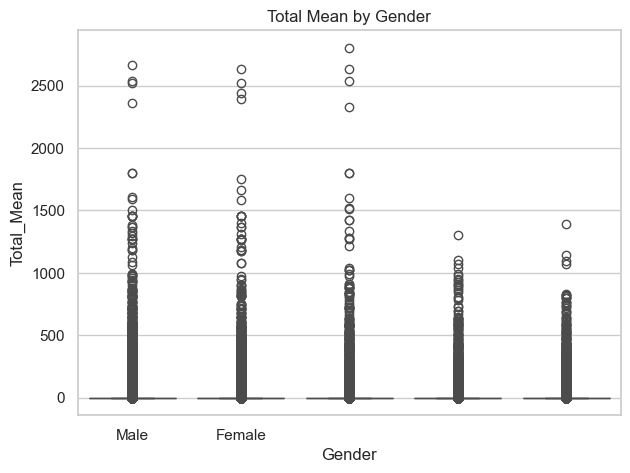

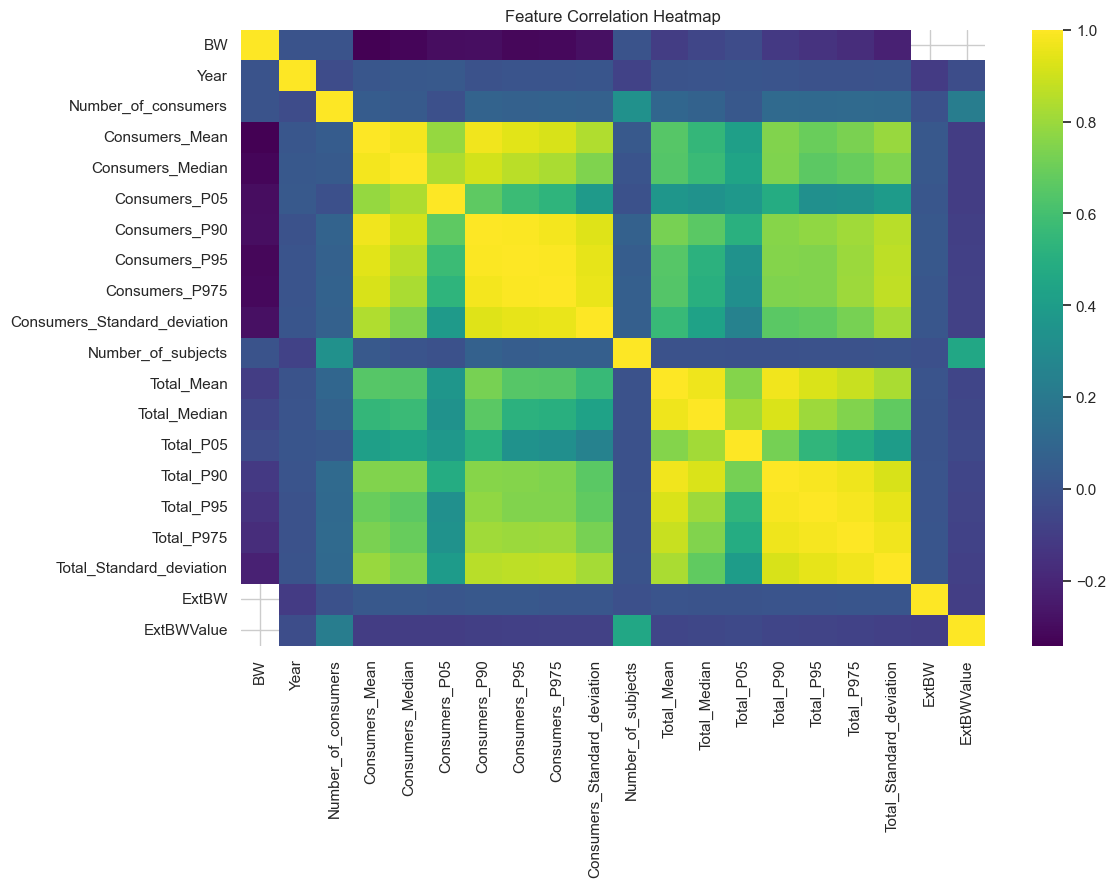

In [6]:
missing = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing)

plt.figure(figsize=(8,5))
sns.histplot(df['Total_Mean'], bins=30, kde=True)
plt.title("Distribution of Total Mean Consumption")
plt.xlabel("Total Mean")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(7,5))
sns.boxplot(x='Gender', y='Total_Mean', data=df)
plt.xticks([0,1], ['Male', 'Female'])
plt.title("Total Mean by Gender")
plt.show()

numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), cmap='viridis', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


Preprocessing

In [7]:
scaled_cols = ['Consumers_Mean', 'Total_Mean', 'ExtBWValue']
df_clean = preprocess_all(df, scaled_cols)
df_clean.head()


D:\Projects\Maching_Learning_final\src\preprocessing.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


Missing values after cleaning: 0
Encoded columns preview:
   BW Country  Year FoodCode   FoodName  Gender  Number_of_consumers  \
0   0   China  2002    A000G  Oat grain     NaN                 1157   
1   0   China  2002    A000G  Oat grain     NaN                  608   
2   0   China  2002    A000G  Oat grain     NaN                  549   
3   0   China  2002    A000N  Buckwheat     NaN                  167   
4   0   China  2002    A000N  Buckwheat     NaN                   82   

   Consumers_Mean  Consumers_Median  Consumers_P05  ...  \
0         60.6230               0.0         8.3333  ...   
1         55.8676               0.0         8.3333  ...   
2         65.8895               0.0        10.0000  ...   
3         55.2645               0.0         8.3333  ...   
4         54.7053               0.0         8.3333  ...   

   SourceAgeClass_6-14 years  SourceAgeClass_>75 years  \
0                      False                     False   
1                      False          

,BW,Country,Year,FoodCode,FoodName,Gender,Number_of_consumers,Consumers_Mean,Consumers_Median,Consumers_P05,...,SourceAgeClass_6-14 years,SourceAgeClass_>75 years,SourceAgeClass_Adolescents,SourceAgeClass_Adults,SourceAgeClass_All,SourceAgeClass_Elderly,SourceAgeClass_Infants,SourceAgeClass_Other children,SourceAgeClass_Toddlers,SourceAgeClass_Very elderly
19147,0,Cyprus,2014,A015G,Linseeds,1.0,1,0.356077,1.67,1.67,...,False,False,True,False,False,False,False,False,False,False
19148,0,Cyprus,2014,A015S,Mustard seeds,1.0,1,0.142857,0.67,0.67,...,False,False,True,False,False,False,False,False,False,False
19167,0,Cyprus,2014,A01AL,Cloves buds,0.0,3,0.006397,0.03,0.03,...,False,False,True,False,False,False,False,False,False,False
19170,0,Cyprus,2014,A016T,Dried herbs,1.0,1,0.070362,0.33,0.33,...,False,False,True,False,False,False,False,False,False,False
19171,0,Cyprus,2014,A016T,Dried herbs,0.0,1,0.070362,0.33,0.33,...,False,False,True,False,False,False,False,False,False,False


Train/Test Split

In [8]:
feature_cols = [
    'Total_P95',
    'Total_P975',
    'Total_Standard_deviation',
    'Total_Median',
    'Consumers_P975',
    'Consumers_P95',
    'Consumers_Standard_deviation',
    'Consumers_Mean'
]
target_col = 'Total_Mean'

# Преобразуем в тензоры
X = torch.tensor(df_clean[feature_cols].values, dtype=torch.float32)
y = torch.tensor(df_clean[target_col].values, dtype=torch.float32).view(-1, 1)

# Разделяем на train/test
test_size = 0.2
num_samples = X.shape[0]
num_test = int(num_samples * test_size)
num_train = num_samples - num_test

X_train, X_test = X[:num_train], X[num_train:]
y_train, y_test = y[:num_train], y[num_train:]

# Создаем DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: torch.Size([44399, 8])
Testing set shape: torch.Size([11099, 8])


Model Training

In [10]:
class TabularCNN(nn.Module):
    def __init__(self, num_features):
        super(TabularCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=2)
        self.relu = nn.ReLU()
        self.fc1 = None
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        if self.fc1 is None:
            self.fc1 = nn.Linear(x.numel() // x.size(0), 64)
            self.fc1.to(x.device)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_features = X_train.shape[1]
cnn_model = TabularCNN(num_features)
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    cnn_model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = cnn_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()


Evaluation

RMSE: 0.0691
R² Score: 0.8546


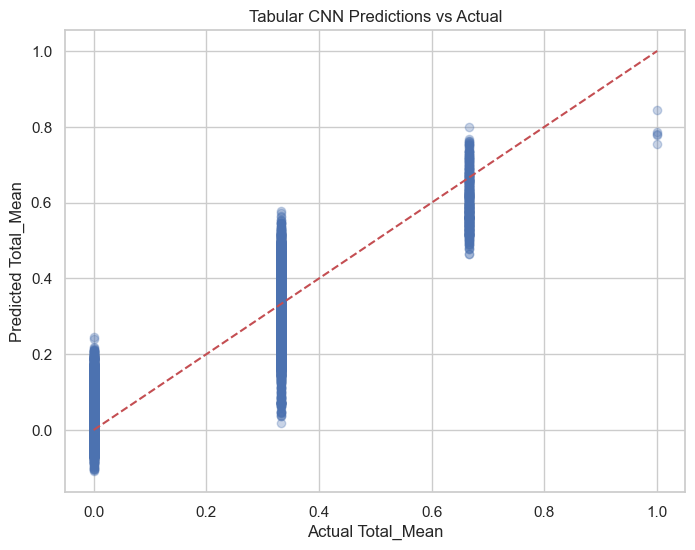

In [13]:
cnn_model.eval()
y_preds = []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = cnn_model(xb)
        y_preds.append(preds)

y_pred = torch.cat(y_preds, dim=0).numpy()
y_true = y_test.numpy()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(8,6))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Total_Mean")
plt.ylabel("Predicted Total_Mean")
plt.title("Tabular CNN Predictions vs Actual")
plt.show()


Save Model

In [15]:
torch.save(cnn_model.state_dict(), "../artifacts/tabular_cnn_model.pth")
print("Model saved to artifacts/tabular_cnn_model.pth")

Model saved to artifacts/tabular_cnn_model.pth
